In [1]:
!pip install -q ecmwf-data ecmwf-opendata magpye cfgrib

In [2]:
import ecmwf.data as ecdata
from magpye import GeoMap
from ecmwf.opendata import Client

In [3]:
import xarray as xr

In [20]:
dem = xr.open_dataset('../graphs/dem.nc')
dem.info()


xarray.Dataset {
dimensions:
	lon = 576 ;
	lat = 576 ;

variables:
	float64 lon(lon) ;
	float64 lat(lat) ;
	float32 z(lat, lon) ;
		z:AREA_OR_POINT = Point ;

// global attributes:
}

In [26]:


def get_elevation(dem, lat, lon):
    elevation = dem.interp(lat=lat, lon=lon, method='linear')
    return elevation['z'].values

In [27]:
get_elevation(dem, 14, 121)


array(nan)

In [4]:
client = Client("ecmwf")

In [5]:
parameters = ['tp']
filename = 'precipitation/medium-tp-mean.grib'

In [6]:
client.retrieve(
    step=[i for i in range(24, 48, 3)],
    stream="enfo",
    type='pf',
    levtype="sfc",
    param=parameters,
    target=filename
)

<multiple>:   0%|          | 0.00/314M [00:00<?, ?B/s]

In [7]:
data = xr.load_dataset(filename, engine='cfgrib')

Ignoring index file 'precipitation/medium-tp-mean.grib.5b7b6.idx' older than GRIB file


In [10]:
data.info()

xarray.Dataset {
dimensions:
	number = 50 ;
	step = 1 ;
	latitude = 721 ;
	longitude = 1440 ;

variables:
	int64 number(number) ;
		number:long_name = ensemble member numerical id ;
		number:units = 1 ;
		number:standard_name = realization ;
	datetime64[ns] time() ;
		time:long_name = initial time of forecast ;
		time:standard_name = forecast_reference_time ;
	timedelta64[ns] step(step) ;
		step:long_name = time since forecast_reference_time ;
		step:standard_name = forecast_period ;
	float64 surface() ;
		surface:long_name = original GRIB coordinate for key: level(surface) ;
		surface:units = 1 ;
	float64 latitude(latitude) ;
		latitude:units = degrees_north ;
		latitude:standard_name = latitude ;
		latitude:long_name = latitude ;
		latitude:stored_direction = decreasing ;
	float64 longitude(longitude) ;
		longitude:units = degrees_east ;
		longitude:standard_name = longitude ;
		longitude:long_name = longitude ;
	datetime64[ns] valid_time(step) ;
		valid_time:standard_name = time ;
	

In [8]:
def interp_data(data, target_lon, target_lat):
    return data.interp(longitude=target_lon, latitude=target_lat, method='linear')

In [18]:
for step, data in data.groupby('step'):
    precipitation_data = interp_data(data, 121, 14)
    print(precipitation_data['tp'].values * 1000)
    

[[ 1.50299072]
 [ 1.92260742]
 [ 5.14221191]
 [ 1.34277344]
 [ 1.64031982]
 [ 3.75366211]
 [ 0.50354004]
 [ 1.06811523]
 [ 2.12097168]
 [ 2.6550293 ]
 [ 0.21362305]
 [ 0.35095215]
 [ 0.29754639]
 [ 0.18310547]
 [ 0.37384033]
 [29.19006348]
 [ 2.80761719]
 [ 2.42614746]
 [ 0.57220459]
 [ 1.35040283]
 [ 0.85449219]
 [ 0.25939941]
 [ 0.35095215]
 [ 8.97216797]
 [ 0.50354004]
 [ 1.90734863]
 [ 0.62561035]
 [ 1.86157227]
 [ 6.34002686]
 [ 2.91442871]
 [ 2.5177002 ]
 [ 0.50354004]
 [ 1.73950195]
 [ 0.15258789]
 [ 3.43322754]
 [22.06420898]
 [ 0.59509277]
 [ 0.77819824]
 [ 0.39672852]
 [ 1.09863281]
 [ 0.59509277]
 [ 0.10681152]
 [ 0.65612793]
 [ 0.96130371]
 [ 1.26647949]
 [ 1.73950195]
 [ 0.44250488]
 [ 4.27246094]
 [ 1.89208984]
 [ 1.44958496]]


In [ ]:
data.info()

In [5]:
data = ecdata.read(filename)

In [6]:
data.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
tp,surface,0,20241114,600,"24,48","0,1,...",228,od,enfo,"cf,pf",0001


In [8]:
tp_0 = data.select(step=24).sort()
tp_1 = data.select(step=48).sort()
tp = tp_1 - tp_0
tp_mean = ecdata.mean(tp) * 1000

In [9]:
tp_mean.describe()

parameter,typeOfLevel,level,date,time,step,paramId,class,stream,type,experimentVersionNumber
tp,surface,0,20241114,600,48,228,od,enfo,cf,0001


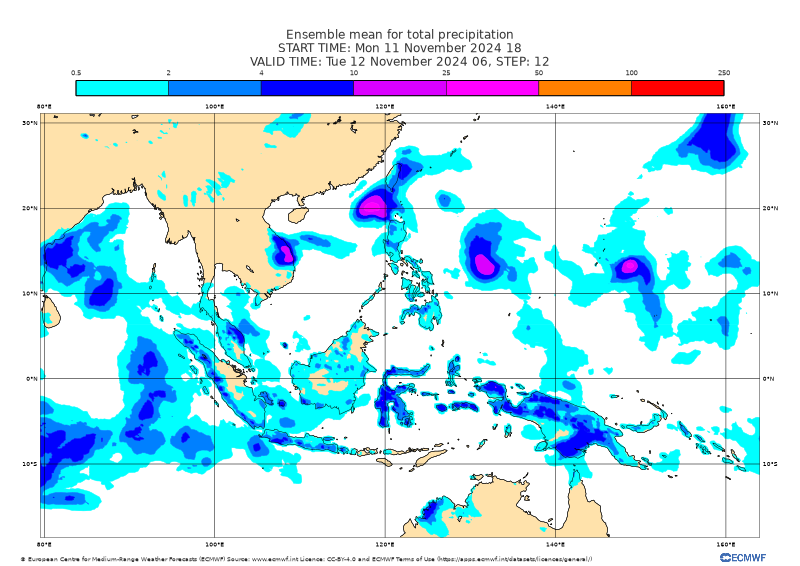

In [19]:
fig = GeoMap(area_name='south_east_asia_and_indonesia')

fig.coastlines(land_colour="cream",resolution="medium")

fig.contour_shaded(tp_mean, style="precipitation_blue_red_250")

fig.coastlines(resolution="medium")
fig.gridlines()

fig.title(["Ensemble mean for total precipitation", 
           "START TIME: <grib_info key='base-date' format='%a %d %B %Y %H' />",
           "VALID TIME: <grib_info key='valid-date' format='%a %d %B %Y %H' />, STEP: <grib_info key='step' />"])
fig.legend()

fig.footer("© European Centre for Medium-Range Weather Forecasts (ECMWF) Source: www.ecmwf.int Licence: CC-BY-4.0 and ECMWF Terms of Use (https://apps.ecmwf.int/datasets/licences/general/)", logo='ecmwf')

fig.show()

### Total Precipitation Probability

In [6]:
# total precipitation probability
parameters = ['tpg1', 'tpg5', 'tpg10', 'tpg20', 'tpg25', 'tpg50', 'tpg100']
precipitation_thresholds = [1, 5, 10, 20, 25, 50, 100]

filename = 'precipitation/tp-probabilities.grib'

In [6]:
client.retrieve(
    time=0,
    step=["24-48"],  # get the forecast for tomorrow
    stream="enfo",
    type="ep",
    param=parameters,
    target=filename  
)

20241114000000-240h-enfo-ep.grib2:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

In [7]:
data = xr.load_dataset(filename, engine='cfgrib')

Ignoring index file 'precipitation/tp-probabilities.grib.5b7b6.idx' older than GRIB file


In [9]:
lat, lon = (14, 121)

In [10]:
def interp_data(data, target_lon, target_lat):
    return data.interp(longitude=target_lon, latitude=target_lat, method='linear')

In [11]:
def get_highest_probability(data):
    # Stack bins into a new dimension called "bin"
    stacked_data = data[parameters].to_array(dim="bin")
    return stacked_data.idxmax(dim="bin")

In [19]:
ds = get_highest_probability(interp_data(data, lon, lat))

<xarray.DataArray 'bin' ()> Size: 8B
array('tpg1', dtype=object)
Coordinates:
    time        datetime64[ns] 8B 2024-11-14
    step        timedelta64[ns] 8B 2 days
    surface     float64 8B 0.0
    valid_time  datetime64[ns] 8B 2024-11-16
    longitude   int64 8B 121
    latitude    int64 8B 14

In [29]:
def convert_to_minimum_precipitation(array: xr.DataArray) -> int:
    """Expects an array of the format above.
    """
    tpg_mapping = {
        name: value for name, value in zip(parameters, precipitation_thresholds)

    }
    return tpg_mapping[array.values]

# Conclusion